In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86831 sha256=2055152be74f5a4c8cf002eb5f0dd7c813a761614d39ee262ba090e8d5ce452b
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=9f421474e287e725c36ad25caa4ce52fe6ce3c77effb2052d471d6d3916501b7
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd     # Read & process data
import seaborn as sns   # Data visualization
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from google.colab import files

from PIL import Image
import umap.umap_ as umap

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10
from PIL import Image
import glob
import cv2

output_notebook()

# Data

In [ ]:
sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})

In [ ]:
root = '/content/drive/MyDrive/Ocean_Hackathon_2023'
path_to_folder_01 = '/content/drive/MyDrive/Ocean_Hackathon_2023/data/APERO_PP_Phytonet_35mu/APERO_PP-Phytonet-01-st01'
path_to_folder_05 = '/content/drive/MyDrive/Ocean_Hackathon_2023/data/APERO_PP_Phytonet_35mu/APERO_PP_Phytonet-05-st11'
path_to_folder = '/content/drive/MyDrive/Ocean_Hackathon_2023/data/APERO_PP_Phytonet_35mu/APERO_PP-Phytonet-12-st32'


path_to_data_01 = path_to_folder_01+'/ecotaxa_APERO_PP-Phytonet-01-st01.tsv'
path_to_data_05 = path_to_folder_05+'/ecotaxa_APERO_PP_Phytonet-05-st11.tsv'
path_to_data = path_to_folder+'/ecotaxa_APERO_PP-Phytonet-12-st32.tsv'
# Load the data into a variable (dict)
df_01 = pd.read_csv(path_to_data_01, sep='\t')
df_05 = pd.read_csv(path_to_data, sep='\t')

In [ ]:
features_of_interest = [
'object_width',
'object_height',
'object_circ',
'object_area_exc',
'object_area',
'object_%area',
'object_major',
'object_minor',
'object_convex_area',
'object_perim',
'object_elongation',
'object_perimareaexc',
'object_perimmajor',
'object_circex',
'object_angle',
'object_bounding_box_area',
'object_eccentricity',
'object_equivalent_diameter',
'object_euler_number',
'object_extent',
'object_local_centroid_col',
'object_local_centroid_row',
'object_solidity',
'object_meanhue',
'object_meansaturation',
'object_meanvalue',
'object_stdhue',
'object_stdsaturation',
'object_stdvalue']

category_to_remove = [
    'dry',
    'multiple<Diatoma',
    'othertocheck',
    'bubble',
    'artefact',
    'transparent',
    'multiple organisms',
    'rods',
    'aggregate',
    'puff',
    't002',
    'clumps',
    'multiple<other',
    'badfocus<other',
    'aggregates',
    'fiber<detritus',
    'badfocus-aggregate',
    'fiber<plastic',
    't001',
    'crumple sphere',
    't003',
    'multiple<Rhizosolenia',
    'detritus',
    'light<detritus',
    'ghost',
    'fecal pellets'
]

# **Species sorted by occurency**

In [ ]:
def count_sp(list_):
  dictio = dict()
  cnt=0
  for value in list_:
    if value in dictio:
      dictio[value]+=1
    else:
      dictio[value]=1
  return dictio

def rm_sp_from_feature(species):
  clean_df=[]
  indices=[]
  for i, sp in enumerate(species):
    if sp not in category_to_remove:
      clean_df.append(sp)
      indices.append(i)
  return clean_df, indices

def del_sp(dict_sp):
  new_dict_species = {sp: dict_sp[sp] for sp in dict_sp if sp not in category_to_remove if dict_sp[sp]>20}
  return new_dict_species

def select_max_species_occurences(dict_species, max):
  i=0
  select_dict_species = dict()
  for k in dict_species.keys():
    i+=1
    if i<=max:
      select_dict_species[k] = dict_species[k]
    else:
      break
  return select_dict_species

def specie_from_txt_to_num(clean_plankton_df, list_descending_order_plankton_species):
  specie_from_txt_to_num = []
  for specie in clean_plankton_df:
    specie_from_txt_to_num.append(list_descending_order_plankton_species.index(str(specie))) # one specie = one num value (descending order)
  return np.array(specie_from_txt_to_num)

def plot_2D(model_emb, specie_num):
  tab = np.zeros(shape=(len(specie_num),3))
  tab[:,0] = model_emb[:,0]
  tab[:,1] = model_emb[:,1]
  tab[:,2] = specie_num
  return tab

def reduce(df, keep_indices):
  df_reduced = pd.DataFrame()
  for index in keep_indices:
    df_reduced = df_reduced.append(df.iloc[index], ignore_index=True)
  return df_reduced.iloc[1:]

def select(plot_, specie_num):
  list_range_max_species = []
  for i, specie in enumerate(plot_):
    for specie_num in range(max):
      if specie[2]==specie_num:
        list_range_max_species.append(specie)
        break
  return list_range_max_species

def make_umap(data_arr, specie_from_txt_to_num):
  fit = umap.UMAP()
  scaled_data = StandardScaler().fit_transform(data_arr)
  model_embedding = fit.fit_transform(scaled_data)

  # merge model_embedding with labels
  plot = plot_2D(model_embedding, specie_from_txt_to_num)

  # keep only most present species
  list_range_max_species = select(plot, specie_from_txt_to_num)

  # convert to np array
  array_range_max_species = np.array(list_range_max_species)

  return array_range_max_species

# array species
def plot_clusters(array_species, img_name):
  # Plot UMAP embeddings with color gradient
  plot_figure.add_tools(HoverTool(tooltips="""
  <div>
      <div>
          <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
      </div>
      <div>
          <span style='font-size: 16px; color: #224499'>Digit:</span>
          <span style='font-size: 18px'>@digit</span>
      </div>
  </div>
  """))
  plt.scatter(array_species[:, 0], array_species[:, 1], c=array_species[:,2], s=5, cmap='Set1')
  cbar = plt.colorbar()
  # Add colorbar for reference
  # color_dict = {specie: f'C{i}' for i, specie in enumerate(selected_species_01)}
  # print(color_dict)
  # legend_labels = [f'{specie}: {color_dict[specie]}' for specie in selected_species_01]
  # print(legend_labels)
  # plt.legend(labels=legend_labels, loc="upper left")
  plt.show()

  # Use KMeans with 3 clusters (you can adjust the number of clusters)
  kmeans = KMeans(n_clusters=max)
  kmeans.fit(array_species[:,:2])

  # Get cluster assignments and centroids
  labels = kmeans.labels_
  centroids = kmeans.cluster_centers_

  # Plot the data points with different colors for each cluster
  plt.scatter(array_species[:, 0], array_species[:, 1], c=labels, cmap='Set1', edgecolors='k', s=50)
  plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, label='Centroids')
  plt.legend()
  plt.title('Species Clustering')

  # plt.savefig(img_name+".png", dpi=300)  # Adjust the filename and dpi as needed
  # files.download(img_name+".png")

  plt.show()

def UMAP_PLOT_SAVE(data_arr, specie_from_txt_to_num):
  return

In [ ]:
# keep order
clean_plankton_species_01, indices_01 = rm_sp_from_feature(df_01['object_annotation_category'][0:])
clean_plankton_species_05, indices_05 = rm_sp_from_feature(df_05['object_annotation_category'][0:])
print(clean_plankton_species_01[1:50])
print(indices_01[1:50])
# print(df_01.head()['object_annotation_category'])
print(df_01['object_annotation_category'][0:10])

['Oithonidae', 'part<Crustacea', 'nauplii<Crustacea', 'Proplectella', 'Neoceratium petersii', 'Phaeocystis', 'Dictyocysta', 'Acantharia', 'Oithonidae', 'nauplii<Crustacea', 'Protoperidinium', 'part<Crustacea', 'Calanoida', 'part<Crustacea', 'Ciliophora', 'Calanoida', 'egg<other', 'Dictyocysta', 'nauplii<Crustacea', 'Neoceratium petersii', 'nauplii<Crustacea', 'nauplii<Crustacea', 'part<Crustacea', 'Neoceratium', 'nauplii<Crustacea', 'nauplii<Crustacea', 'Oithonidae', 'Oithonidae', 'Oithonidae', 'molt', 'nauplii<Crustacea', 'nauplii<Crustacea', 'Oithonidae', 'nauplii<Crustacea', 'Neoceratium', 'Dictyocysta', 'nauplii<Crustacea', 'Dictyocysta', 'Neoceratium petersii', 'Dictyocysta', 'Oithonidae', 'Oithonidae', 'part<Crustacea', 'Undella', 'nauplii<Crustacea', 'Neoceratium petersii', 'Dictyocysta', 'Neoceratium petersii', 'Neoceratium']
[1, 2, 3, 5, 8, 10, 13, 16, 18, 22, 23, 24, 29, 30, 33, 35, 41, 42, 43, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71

In [ ]:
new_dict_01 = count_sp(clean_plankton_species_01)
dictio_sort_01 = dict(sorted(new_dict_01.items(), key=lambda item: item[1], reverse=True))
print(dictio_sort_01)

new_dict_05 = count_sp(clean_plankton_species_05)
dictio_sort_05 = dict(sorted(new_dict_05.items(), key=lambda item: item[1], reverse=True))
print(dictio_sort_05)

{'nauplii<Crustacea': 326, 'part<Crustacea': 178, 'Oithonidae': 130, 'Proplectella': 65, 'Undella': 58, 'Dictyocysta': 57, 'Neoceratium': 46, 'Neoceratium petersii': 44, 'molt': 44, 'Neoceratium fusus<Neoceratium': 19, 'Calanoida': 17, 'egg<other': 16, 'Phaeocystis': 14, 'Rhabdonellopsis': 13, 'Rhizosolenia': 12, 'multiple<Copepoda': 11, 'Trichodesmium': 9, 'copepoda-cut': 8, 'Acantharia': 7, 'Ciliophora': 7, 'Salpingella<Tintinnidiidae': 7, 'Planktoniella sol': 6, 'sphere<detritus': 6, 'Thalassiosira': 5, 'Dinophyceae': 5, 'Neoceratium macroceros': 5, 'Parundella<Xystonellidae': 5, 'Neoceratium pentagonum': 5, 'Protoperidinium': 4, 'Neoceratium 01': 4, 'Neoceratium platycorne': 4, 'egg sac<egg': 4, 'Cyclopoida': 4, 'Sticholonche': 4, 'Neoceratium furca<Neoceratium': 3, 'Copepoda<Maxillopoda': 3, 'unidentified cells': 2, 'dinophysis schuettii<Dinophysis': 2, 'pennate<Bacillariophyta': 2, 'Amphorides<Tintinnidiidae': 2, 'Oncaeidae': 2, '[t]': 1, 'Pterosperma': 1, 'Dinophysis caudata<Din

In [ ]:
list_descending_order_plankton_species_01 = list(dictio_sort_01)
list_descending_order_plankton_species_05 = list(dictio_sort_05)

print(list_descending_order_plankton_species_01)
print(list_descending_order_plankton_species_05)

['nauplii<Crustacea', 'part<Crustacea', 'Oithonidae', 'Proplectella', 'Undella', 'Dictyocysta', 'Neoceratium', 'Neoceratium petersii', 'molt', 'Neoceratium fusus<Neoceratium', 'Calanoida', 'egg<other', 'Phaeocystis', 'Rhabdonellopsis', 'Rhizosolenia', 'multiple<Copepoda', 'Trichodesmium', 'copepoda-cut', 'Acantharia', 'Ciliophora', 'Salpingella<Tintinnidiidae', 'Planktoniella sol', 'sphere<detritus', 'Thalassiosira', 'Dinophyceae', 'Neoceratium macroceros', 'Parundella<Xystonellidae', 'Neoceratium pentagonum', 'Protoperidinium', 'Neoceratium 01', 'Neoceratium platycorne', 'egg sac<egg', 'Cyclopoida', 'Sticholonche', 'Neoceratium furca<Neoceratium', 'Copepoda<Maxillopoda', 'unidentified cells', 'dinophysis schuettii<Dinophysis', 'pennate<Bacillariophyta', 'Amphorides<Tintinnidiidae', 'Oncaeidae', '[t]', 'Pterosperma', 'Dinophysis caudata<Dinophysis', 'Gonyaulacales', 'Foraminifera', 'Neoceratium arietinum', 'Eutintinnus', 'Rhizaria', 'Amphisolenia']
['Rhizosolenia', 'nauplii<Crustacea',

In [ ]:
specie_from_txt_to_num_01 = specie_from_txt_to_num(clean_plankton_species_01[1:], list_descending_order_plankton_species_01)
specie_from_txt_to_num_05 = specie_from_txt_to_num(clean_plankton_species_05[1:], list_descending_order_plankton_species_05)

print(specie_from_txt_to_num_01.shape)
print(specie_from_txt_to_num_05.shape)

(1173,)
(2199,)


# **Select most present species**

In [ ]:
max=5
selected_species_01 = select_max_species_occurences(dictio_sort_01,max)
selected_species_05 = select_max_species_occurences(dictio_sort_05,max)

print(selected_species_01)
print(selected_species_05)

{'nauplii<Crustacea': 326, 'part<Crustacea': 178, 'Oithonidae': 130, 'Proplectella': 65, 'Undella': 58}
{'Rhizosolenia': 328, 'nauplii<Crustacea': 306, 'Neoceratium fusus<Neoceratium': 286, 'Amphorides<Tintinnidiidae': 148, 'Neoceratium furca<Neoceratium': 144}


In [ ]:
df_reduced_01 = reduce(df_01, indices_01)
df_reduced_05 = reduce(df_05, indices_05)
# for index in indices_01:
#   df_reduced_01 = df_reduced_01.append(df_01.iloc[index], ignore_index=True)
# df_reduced_01 = df_reduced_01.iloc[1:]

<ipython-input-7-582fb6b9afcc>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_reduced = df_reduced.append(df.iloc[index], ignore_index=True)
<ipython-input-7-582fb6b9afcc>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_reduced = df_reduced.append(df.iloc[index], ignore_index=True)


In [ ]:
# print(df_reduced_01.iloc[5]['object_annotation_category'])
# print(df_reduced_01.iloc[0]['object_annotation_category'])
# print(df_reduced_01[df_reduced_01.keys()[0]].size-1)

print(df_reduced_05.iloc[5]['object_annotation_category'])
print(df_reduced_05.iloc[0]['object_annotation_category'])
print(df_reduced_05[df_reduced_05.keys()[0]].size-1)

Neoceratium petersii
Neoceratium furca<Neoceratium
2198


In [ ]:
size_of_samples_01 = df_reduced_01[df_reduced_01.keys()[0]].size-1
data_array_01 = np.zeros((size_of_samples_01, len(features_of_interest)))
print(data_array_01.shape)

for i, feature in enumerate(features_of_interest):
  for key in df_reduced_01.keys():
    if(str(key)==str(feature)):
      # keep only relevant features
      data_array_01[:,i] = df_reduced_01[str(key)][1:] # make sure of the right dimension (i is the feature and : are samples)
      break;

print(data_array_01[0])

(1172, 29)
[1.34000000e+02 1.41000000e+02 0.00000000e+00 3.81400000e+03
 4.48900000e+03 1.50367565e-01 1.09897881e+02 9.37457357e+01
 1.14910000e+04 0.00000000e+00 1.17229739e+00 2.13977109e-01
 7.42606395e+00 7.19605616e-02 6.18691106e+01 1.88940000e+04
 5.21868629e-01 6.96859787e+01 0.00000000e+00 2.01863025e-01
 7.50015732e+01 7.98550079e+01 3.31911931e-01 6.60004455e+01
 3.05814213e+00 2.37165070e+02 5.92965370e+01 5.23861089e+00
 2.80443221e+01]


In [ ]:
size_of_samples_05 = df_reduced_05[df_reduced_05.keys()[0]].size-1
data_array_05 = np.zeros((size_of_samples_05, len(features_of_interest)))
print(data_array_05.shape)

for i, feature in enumerate(features_of_interest):
  for key in df_reduced_05.keys():
    if(str(key)==str(feature)):
      # keep only relevant features
      data_array_05[:,i] = df_reduced_05[str(key)][1:] # make sure of the right dimension (i is the feature and : are samples)
      break;

print(data_array_05[0])

(2198, 29)
[1.40000000e+02 1.67000000e+02 0.00000000e+00 6.64400000e+03
 6.64400000e+03 0.00000000e+00 1.72933165e+02 9.62672889e+01
 1.39270000e+04 0.00000000e+00 1.79638553e+00 1.36163785e-01
 5.23134001e+00 1.02013351e-01 1.29435306e+02 2.33800000e+04
 8.30731456e-01 9.19750158e+01 1.00000000e+00 2.84174508e-01
 7.73544551e+01 8.21875376e+01 4.77058950e-01 7.36684226e+01
 1.17343468e+01 2.29098134e+02 6.07902313e+01 1.84508807e+01
 3.28480209e+01]


In [ ]:
example_data_array = make_umap(data_array_01, specie_from_txt_to_num_01[1:])

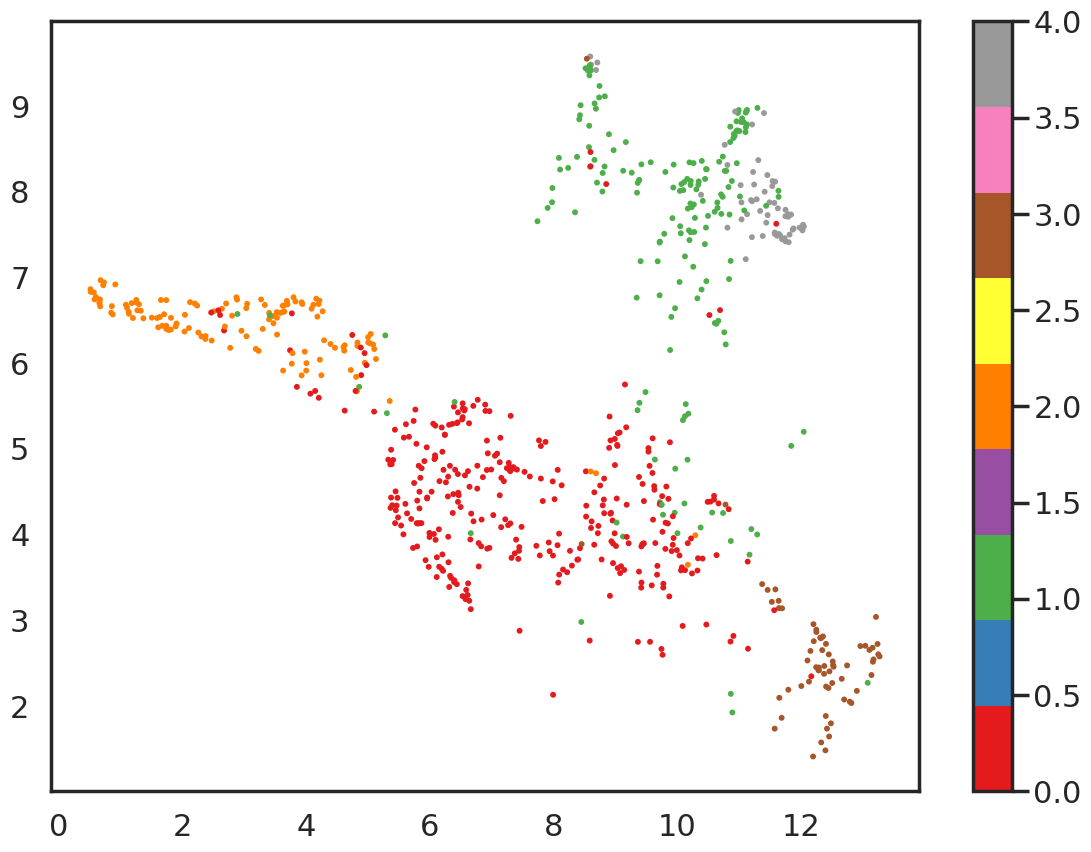

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

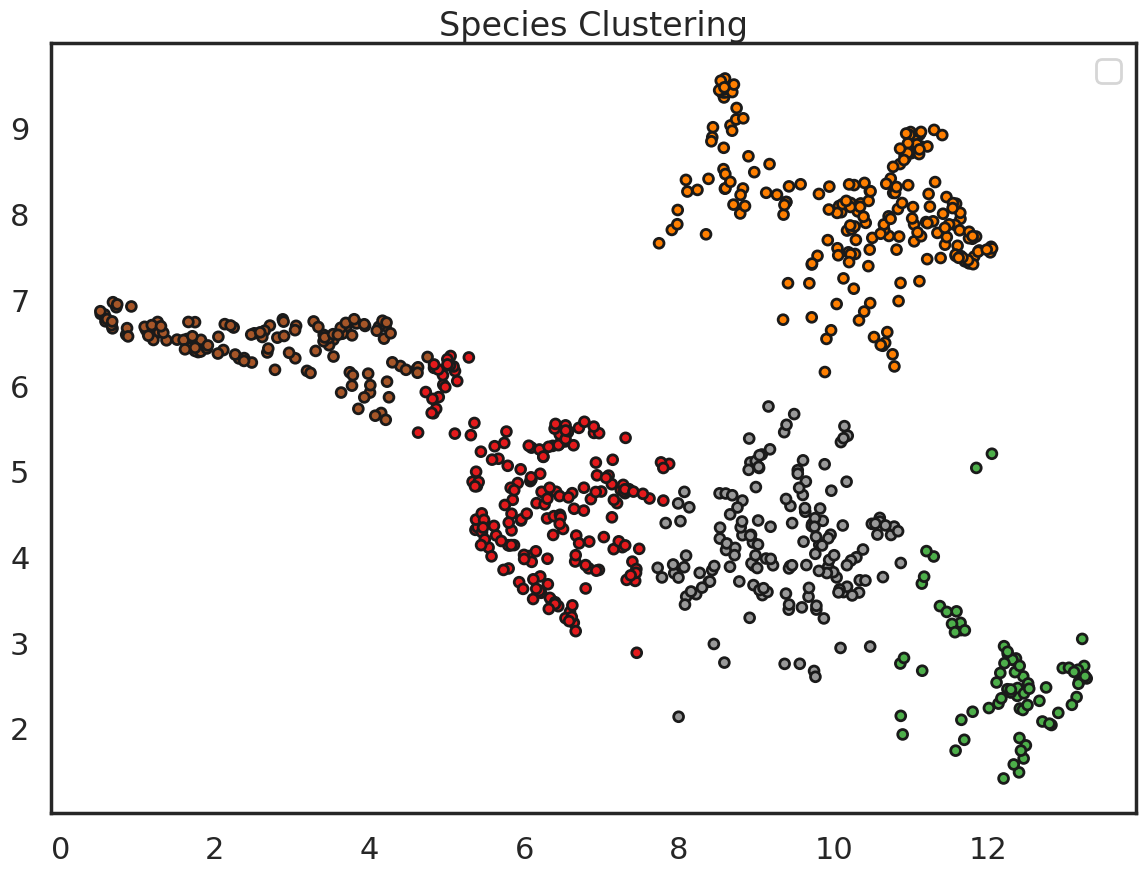

In [ ]:
presentation_cluster1 = 'presentation_cluster_01'
plot_clusters(example_data_array, presentation_cluster1)

In [ ]:
path_to_img = '/content/drive/MyDrive/Ocean_Hackathon_2023/data/APERO_PP_Phytonet_35mu/APERO_PP-Phytonet-01-st01/*.jpg'
img_list = []
for filename in glob.glob(path_to_img):
  im=Image.open(filename)
  img_list.append(im)

In [ ]:
opencv_image = cv2.imread("logo.png")
cv2.imshow("OpenCV Image", opencv_image)

DisabledFunctionError: ignored

In [ ]:
for i in range(0,200):
  if df_01.iloc[i]['img_file_name'] in img_list.keys():
    print(df_01.iloc[i]['img_file_name'])
    print(df_01.iloc[i]['object_annotation_category'])

In [ ]:
model_embedding_05 = make_umap(data_array_05, specie_from_txt_to_num_05[1:])

In [ ]:
plot_01 = plot_2D(model_embedding_01, specie_from_txt_to_num_01[1:])
print(plot_01.shape)

list_range_max_species_01 = select(plot_01, specie_from_txt_to_num_01)

In [ ]:
plot_05 = plot_2D(model_embedding_05, specie_from_txt_to_num_05[1:])
list_range_max_species_05 = select(plot_05, specie_from_txt_to_num_05)

print(plot_05.shape)
print(list_range_max_species_05)

# **Color gradient for species**

In [ ]:
from sklearn.cluster import KMeans

array_range_max_species_01 = np.array(list_range_max_species_01)
# Plot UMAP embeddings with color gradient
plt.figure(figsize=(35,20))
plt.subplot(121)
plt.scatter(array_range_max_species_01[:, 0], array_range_max_species_01[:, 1], c=array_range_max_species_01[:,2], s=5, cmap='Set1')

# Add colorbar for reference
cbar = plt.colorbar()
color_dict = {specie: f'C{i}' for i, specie in enumerate(selected_species_01)}
print(color_dict)
legend_labels = [f'{specie}: {color_dict[specie]}' for specie in selected_species_01]
print(legend_labels)
plt.legend(labels=legend_labels, loc="upper left")


plt.subplot(122)
# Use KMeans with 3 clusters (you can adjust the number of clusters)
kmeans = KMeans(n_clusters=max)
kmeans.fit(array_range_max_species_01[:,:2])

# Get cluster assignments and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Plot the data points with different colors for each cluster
plt.scatter(array_range_max_species_01[:, 0], array_range_max_species_01[:, 1], c=labels, cmap='viridis', edgecolors='k', s=50)
# plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='array_range_max_species_01', s=200, label='Centroids')
plt.legend()
plt.title('KMeans Clustering')
plt.xlabel('X')
plt.ylabel('Y')

plt.show()

In [ ]:
from sklearn.cluster import KMeans

# Use KMeans with 3 clusters (you can adjust the number of clusters)
kmeans = KMeans(n_clusters=max)
kmeans.fit(array_range_max_species_01[:,:2])

# Get cluster assignments and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Plot the data points with different colors for each cluster
plt.scatter(array_range_max_species_01[:, 0], array_range_max_species_01[:, 1], c=labels, cmap='viridis', edgecolors='k', s=50)
# plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='array_range_max_species_01', s=200, label='Centroids')
plt.legend()
plt.title('KMeans Clustering')
plt.xlabel('X')
plt.ylabel('Y')

In [ ]:
array_range_max_species_05 = np.array(list_range_max_species_05)
# Plot UMAP embeddings with color gradient
plt.scatter(array_range_max_species_05[:, 0], array_range_max_species_05[:, 1], c=array_range_max_species_05[:,2], s=5, cmap='Set1')
# Add colorbar for reference
cbar = plt.colorbar()
cbar.set_label('specie', rotation=270, labelpad=15)

plt.show()

# **Color gradient for area**

# **UMAP hyperparameters**

We will play with these major ones:
- n_neighbors
- min_dist
- n_components
- metric

We seek for the hyperparameters that best

In [ ]:
def create_data(file_path):
  table=pd.read_table(file_path)
  data=np.zeros((len(table)-1,len(MY_KEYS)))

  j=0
  for key in MY_KEYS :
    column=table[key]
    column=np.array(column[1:])
    for i in range(len(column)):
      data[i,j]=column[i]
    j+=1

  return data

def create_umap(data,n_neighbors=15,min_dist=0.1,n_components=2,metric='euclidean'):
  reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,n_components=n_components,metric=metric)
  reducer.fit(data)
  embedding = reducer.transform(data)

  return embedding

In [ ]:
# Hyperparameters
n_neighbors=28
min_dist=0.2
n_components=2
metric='euclidean'

umap1=create_umap(data_array,n_neighbors,min_dist,n_components,metric)

In [ ]:
plt.scatter(umap1[:, 0], umap1[:, 1],color='r', s=5)
plt.gca().set_aspect('equal', 'datalim')
# image_name=f'UMAP projection of [{os.path.basename(file_path1)}] and [{os.path.basename(file_path2)}] \nParameters : {n_neighbors},{min_dist},{n_components},{metric}'
# plt.title(image_name, fontsize=24);

# plt.savefig(image_name+".png", dpi=300)  # Adjust the filename and dpi as needed
# files.download(image_name+".png")
plt.show()